In [1]:
import warnings

# Coisa do Windows

# Ignorar o warning específico do KMeans
warnings.filterwarnings("ignore", message="KMeans is known to have a memory leak")
# Voltar ao normal
# warnings.filterwarnings("default")

# Trabalho Prático 1 de Ciência de Dados

## Imports

In [2]:
!pip install unidecode

In [3]:
import pandas as pd
import nltk
import string
import unidecode
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
nltk.download("punkt_tab")
nltk.download('stopwords')

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\alanz\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\alanz\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [4]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
from sklearn.cluster import KMeans
import seaborn as sns
from sklearn.cluster import SpectralClustering
from sklearn.neighbors import kneighbors_graph
from scipy.sparse import csgraph
from numpy import linalg as LA
from sklearn.cluster import AgglomerativeClustering

from sklearn.metrics import silhouette_samples, silhouette_score

## Download e leitura

#### Download dos dados

In [5]:
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1AeYgV89TmYvNC__RDXr8hS0P6WOsChWg' -O filmes.csv

'wget' n�o � reconhecido como um comando interno
ou externo, um programa oper�vel ou um arquivo em lotes.
'id' n�o � reconhecido como um comando interno
ou externo, um programa oper�vel ou um arquivo em lotes.


#### Leitura dos dados

In [6]:
filmes_df = pd.read_csv("filmes.csv")
filmes_df.head()

,genres,averageRating,numVotes,sinopse,primaryTitle,startYear,runtimeMinutes,actors_names,directors_names
0,Family,7.1,387992,When two kids find and play a magical board ga...,Jumanji,1995,104,['Robin Williams' 'Jonathan Hyde' 'Jonathan Hy...,['Joe Johnston']
1,Romance,6.7,30265,John and Max resolve to save their beloved bai...,Grumpier Old Men,1995,101,['Walter Matthau' 'Jack Lemmon' 'Burgess Mered...,['Howard Deutch']
2,Romance,6.0,12585,"Based on Terry McMillan's novel, this film fol...",Waiting to Exhale,1995,124,['Gregory Hines' 'Dennis Haysbert' 'Mykelti Wi...,['Forest Whitaker']
3,"Romance,Family",6.1,42555,George Banks must deal not only with his daugh...,Father of the Bride Part II,1995,106,['Steve Martin' 'Martin Short' 'George Newbern...,['Charles Shyer']
4,"Crime,Action",8.3,738636,A group of high-end professional thieves start...,Heat,1995,170,['Al Pacino' 'Robert De Niro' 'Val Kilmer' 'Jo...,['Michael Mann']


## Pré-processamento dos dados

#### Convertendo os tokens

Convertendo todos os tokens para letras minúsculas

In [7]:
def tokens_low(tokens):
  return [w.lower() for w in tokens]

Removendo os símbolos de pontuação

In [8]:
table = str.maketrans('', '', string.punctuation)

In [9]:
def tokens_pontuacao(tokens):
  return [w.translate(table) for w in tokens]

Convertendo carcteres especiais

In [10]:
def tokens_char_especical(tokens):
  return [unidecode.unidecode(w).lower() for w in tokens]

#### Filtrando apenas palavras

Extraindo apenas as palavras da lista de tokens

In [11]:
def tokens_apenas_words(tokens):
  return [word for word in tokens if word.isalpha()]

Removendo stop words

In [12]:
stop_words = set(stopwords.words('english'))

In [13]:
def tokens_stop_words(tokens):
  return [word for word in tokens if not word in stop_words]

#### Stemming

In [14]:
porter = PorterStemmer()

In [15]:
def tokens_stemming(tokens):
  return [porter.stem(word) for word in tokens]

#### Tokenizer Personalizado

In [16]:
def tokenizer_personalizado(texto):
  tokens = word_tokenize(texto)

  tokens = tokens_low(tokens)
  tokens = tokens_pontuacao(tokens)
  tokens = tokens_char_especical(tokens)
  tokens = tokens_apenas_words(tokens)
  tokens = tokens_stop_words(tokens)
  tokens = tokens_stemming(tokens)

  return tokens

## Configuração do Vectonizer - TF-IDF

In [17]:
vectorizer = TfidfVectorizer(tokenizer=tokenizer_personalizado, max_features=3500, max_df=0.8, ngram_range=(1,3))

## K-means

### Configuração dos Dados

In [18]:
filmes_kmeans_df = filmes_df[['genres', 'sinopse']].copy()
filmes_kmeans_df['genres_list'] = filmes_kmeans_df['genres'].apply(lambda x: x.split(sep=','))
filmes_kmeans_df

,genres,sinopse,genres_list
0,Family,When two kids find and play a magical board ga...,[Family]
1,Romance,John and Max resolve to save their beloved bai...,[Romance]
2,Romance,"Based on Terry McMillan's novel, this film fol...",[Romance]
3,"Romance,Family",George Banks must deal not only with his daugh...,"[Romance, Family]"
4,"Crime,Action",A group of high-end professional thieves start...,"[Crime, Action]"
...,...,...,...
30353,Biography,"""I'll look at you, but not at the camera. It c...",[Biography]
30354,Biography,A musical biography of the great Russian class...,[Biography]
30355,"Crime,Horror",An evil genius uses poison gas to avenge himse...,"[Crime, Horror]"
30356,Romance,A young man narrates his past on how his fathe...,[Romance]


In [19]:
# Filmes com mais de um genero foram multiplicados para que existam apenas um genero por filme
filmes_kmeans_df = filmes_kmeans_df.explode('genres_list')
filmes_kmeans_df

,genres,sinopse,genres_list
0,Family,When two kids find and play a magical board ga...,Family
1,Romance,John and Max resolve to save their beloved bai...,Romance
2,Romance,"Based on Terry McMillan's novel, this film fol...",Romance
3,"Romance,Family",George Banks must deal not only with his daugh...,Romance
3,"Romance,Family",George Banks must deal not only with his daugh...,Family
...,...,...,...
30354,Biography,A musical biography of the great Russian class...,Biography
30355,"Crime,Horror",An evil genius uses poison gas to avenge himse...,Crime
30355,"Crime,Horror",An evil genius uses poison gas to avenge himse...,Horror
30356,Romance,A young man narrates his past on how his fathe...,Romance


### TF-IDF

In [20]:
X = vectorizer.fit_transform(filmes_kmeans_df['sinopse'])

c:\Users\alanz\anaconda3\Lib\site-packages\sklearn\feature_extraction\text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [21]:
matriz_tf_idf = pd.DataFrame(X.todense(), columns = vectorizer.get_feature_names_out())
matriz_tf_idf

,abandon,abduct,abil,abl,aboard,abroad,abus,academi,accept,access,...,young son,young woman,young women,younger,younger brother,youngest,youngster,youth,zombi,zone
0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37557,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
37558,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
37559,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
37560,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Dimensionalidade - SVD

In [22]:
svd = make_pipeline(TruncatedSVD(n_components=3500), Normalizer(copy=False))

In [23]:
svd.fit(X)

Pipeline(steps=[('truncatedsvd', TruncatedSVD(n_components=3500)),
                ('normalizer', Normalizer(copy=False))])

#### Curva - Fração Cumulativa da Variância Explicada

Text(0, 0.5, '$f(k)$ - Fração cumulativa da variância explicada')

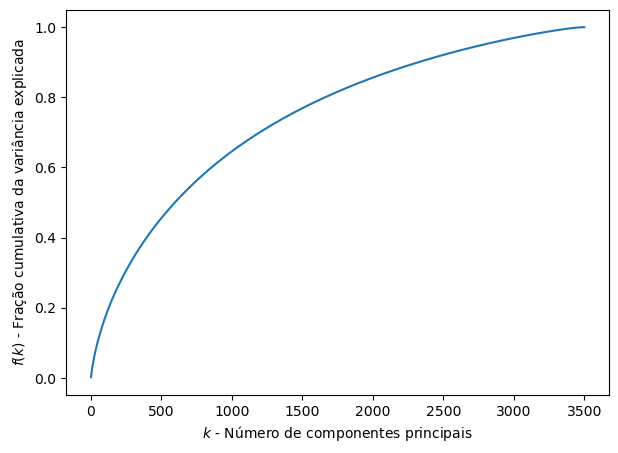

In [24]:
fig = plt.figure(figsize=(7, 5))
plt.plot([i for i in range(1, svd[0].n_components + 1)], np.cumsum(svd[0].explained_variance_ratio_))
plt.xlabel(r'$k$ - Número de componentes principais')
plt.ylabel(r'$f(k)$ - Fração cumulativa da variância explicada')

In [25]:
X_REDUCED = svd.transform(X)

### Verificando o K-means - Escolha do K

#### Função Objetivo

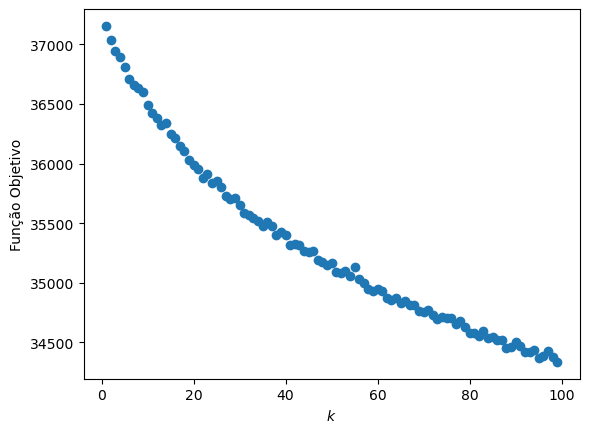

In [26]:
inertia = []
max_groups = 100
for i in range(1, max_groups):
  km = KMeans(n_clusters = i)
  km.fit(X_REDUCED)
  inertia.append(km.inertia_)

plt.scatter(range(1, max_groups), inertia)
_ = plt.ylabel("Função Objetivo")
_ = plt.xlabel(r"$k$")

#### Coeficiente de Silhueta

For n_clusters = 9 The average silhouette_score is : 0.00470983592406963
For n_clusters = 10 The average silhouette_score is : 0.00492725375450086
For n_clusters = 12 The average silhouette_score is : 0.005775815389961724
For n_clusters = 23 The average silhouette_score is : 0.008530538878446304
For n_clusters = 40 The average silhouette_score is : 0.011183335129486351


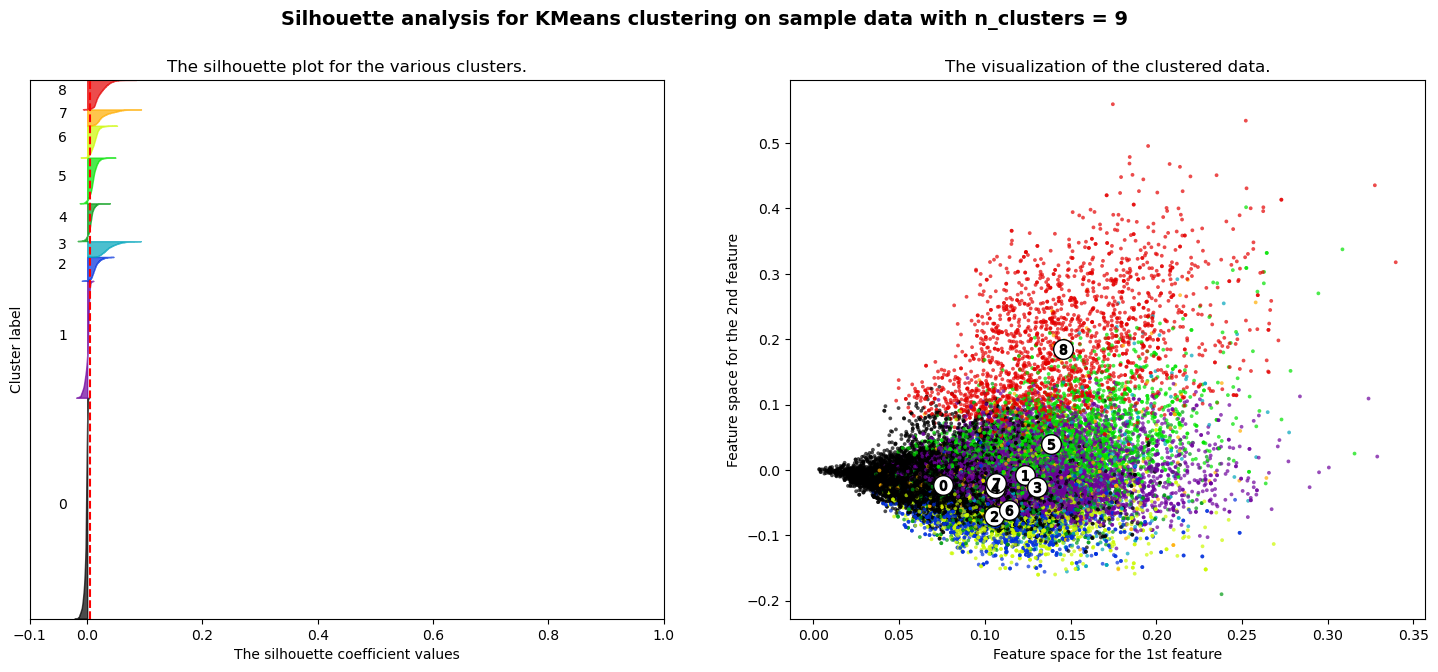

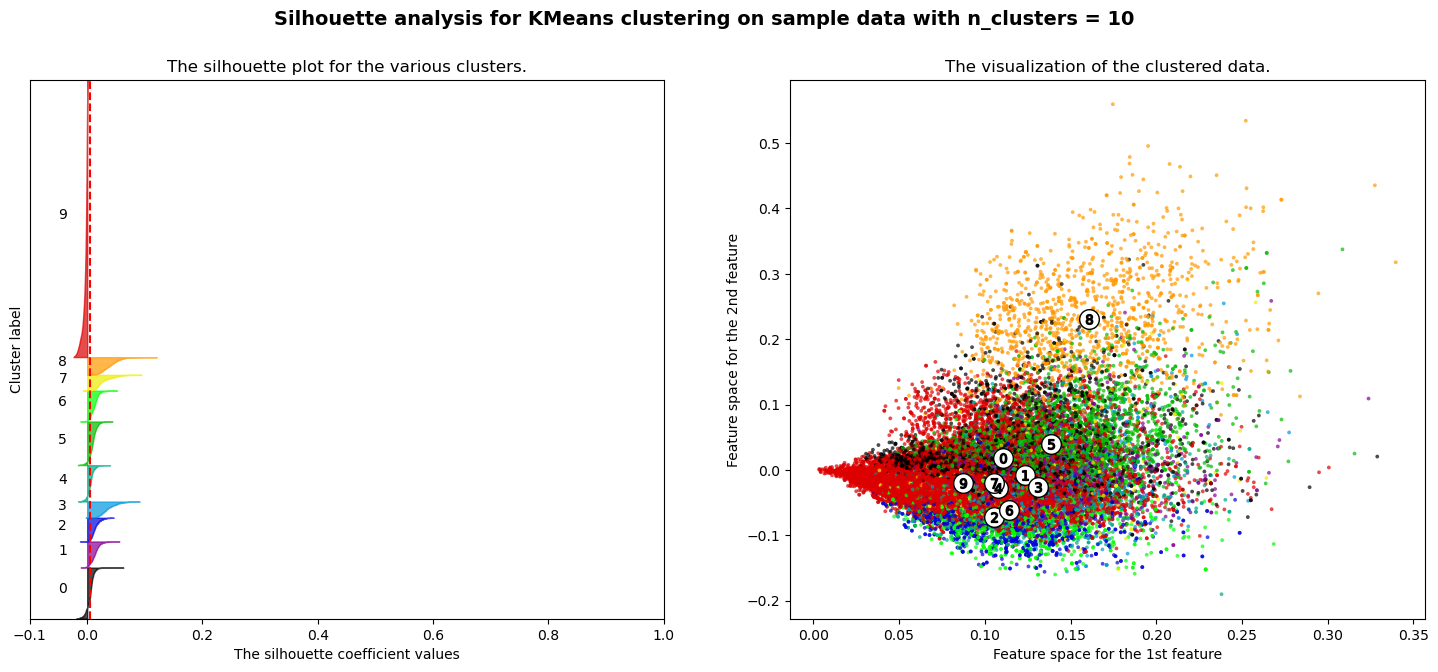

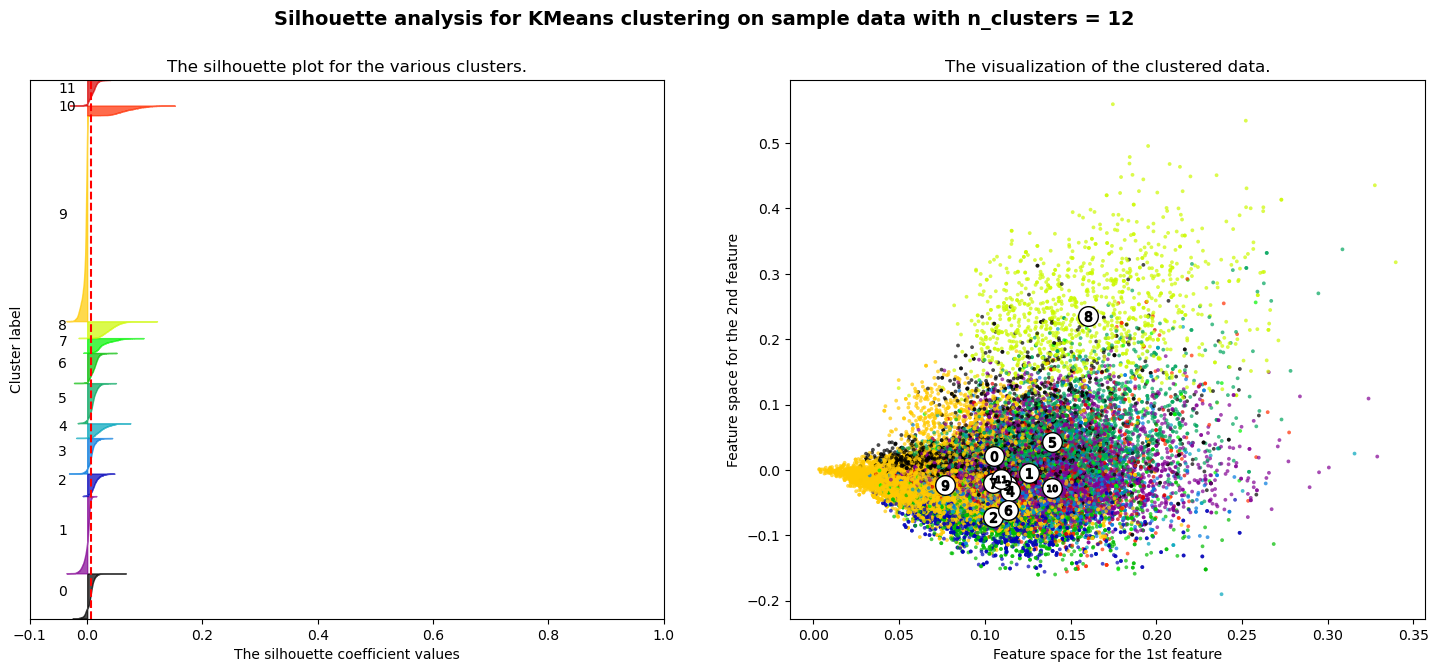

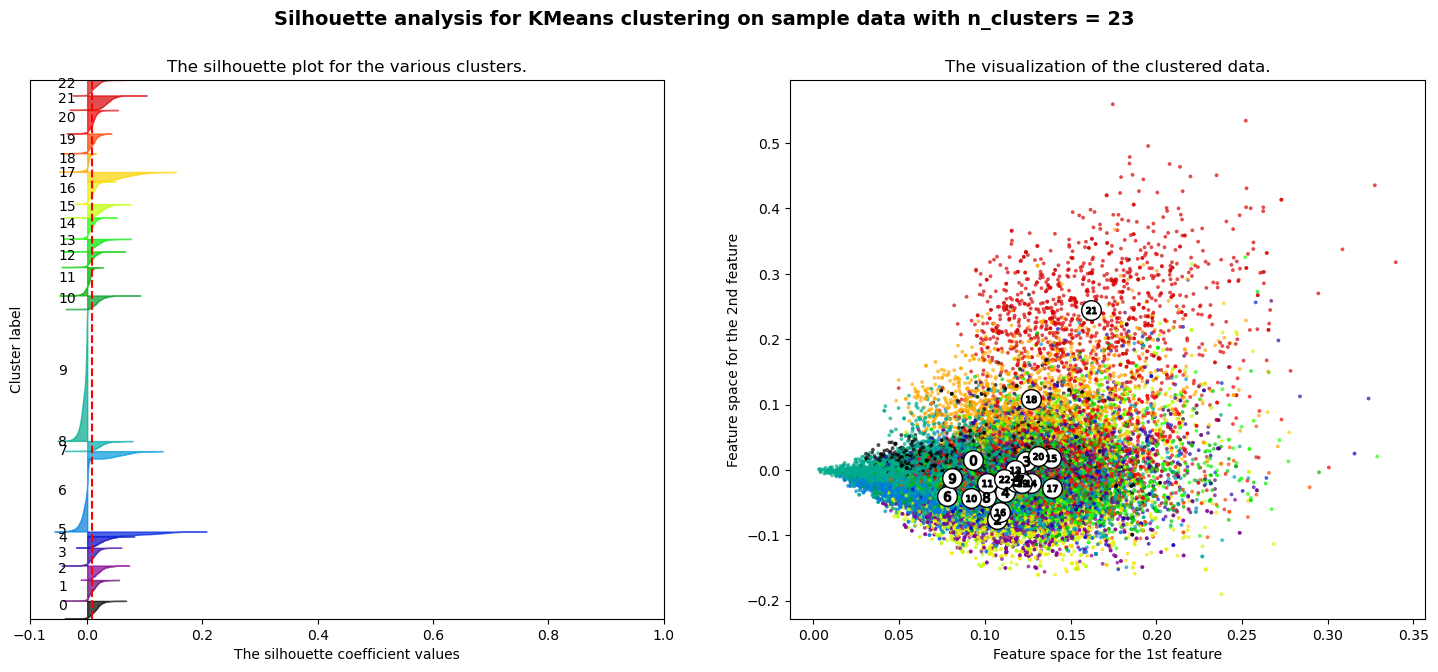

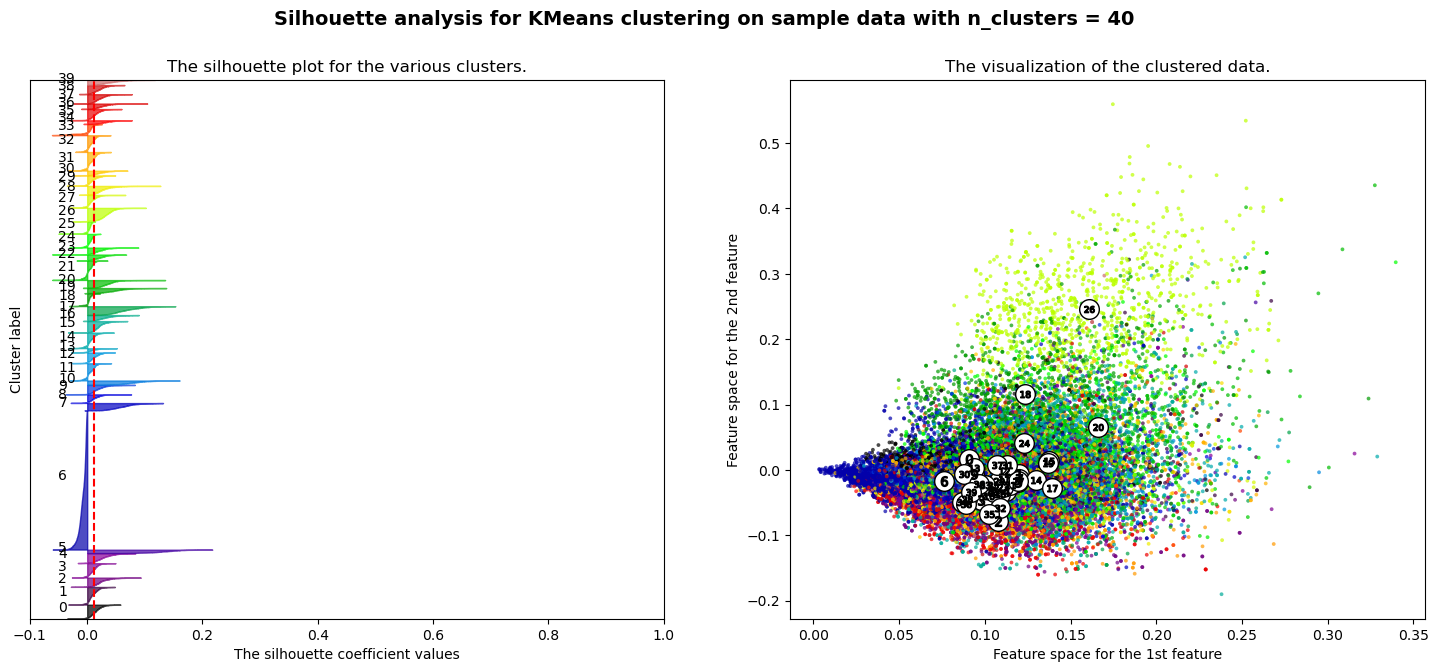

In [27]:
X_DENSE = X_REDUCED

range_n_clusters = [9, 10, 12, 23, 40]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X_DENSE) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X_DENSE)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X_DENSE, cluster_labels)
    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is :",
        silhouette_avg,
    )

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X_DENSE, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(
        X_DENSE[:, 0], X_DENSE[:, 1], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k"
    )

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(
        centers[:, 0],
        centers[:, 1],
        marker="o",
        c="white",
        alpha=1,
        s=200,
        edgecolor="k",
    )

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(
        "Silhouette analysis for KMeans clustering on sample data with n_clusters = %d"
        % n_clusters,
        fontsize=14,
        fontweight="bold",
    )

### Agrupando

In [28]:
k_groups = 23
kmeans = KMeans(n_clusters = k_groups)
kmeans.fit(X_REDUCED)
y_kmeans = kmeans.predict(X_REDUCED)

### Análise dos Grupos

#### Atribuindo os Grupos

In [29]:
filmes_kmeans_df['grupos'] = y_kmeans

#### Matriz Generos X Grupos

In [30]:
generosXgrupos = filmes_kmeans_df.groupby(['genres_list', 'grupos']).size().unstack(fill_value=0)
generosXgrupos

grupos,0,1,2,3,4,5,6,7,8,9,...,13,14,15,16,17,18,19,20,21,22
genres_list,,,,,,,,,,,,,,,,,,,,,
Action,91,42,133,266,159,151,237,147,184,96,...,207,2866,67,85,188,234,324,358,166,787
Biography,44,9,9,33,37,64,23,26,59,28,...,4,902,17,33,368,32,10,11,43,59
Crime,36,164,146,834,284,206,278,209,253,190,...,16,2650,77,97,230,206,214,518,154,336
Family,16,0,59,17,30,90,131,157,191,35,...,47,722,49,22,81,67,7,5,42,94
Horror,18,151,207,379,306,218,277,256,317,45,...,121,2075,75,40,89,85,31,60,91,243
Musical,13,0,26,10,30,42,37,82,30,36,...,8,475,13,82,43,17,5,5,20,15
Romance,104,8,140,89,707,430,417,455,347,200,...,20,2820,179,722,370,149,46,35,115,109
Sci-Fi,13,9,61,64,65,100,47,39,61,19,...,360,1013,20,12,39,21,62,29,50,129
Sport,5,1,15,3,10,21,27,20,23,7,...,1,367,47,9,54,32,5,1,14,44


**Grupos ordenados em ordem decrescente em relação à quantidade de filmes nos grupos**

In [31]:
generosXgrupos = generosXgrupos[generosXgrupos.sum().sort_values(ascending=False).index]
generosXgrupos

grupos,14,10,22,3,4,6,8,17,7,5,...,12,2,13,19,21,9,15,1,0,11
genres_list,,,,,,,,,,,,,,,,,,,,,
Action,2866,381,787,266,159,237,184,188,147,151,...,179,133,207,324,166,96,67,42,91,33
Biography,902,97,59,33,37,23,59,368,26,64,...,26,9,4,10,43,28,17,9,44,22
Crime,2650,479,336,834,284,278,253,230,209,206,...,73,146,16,214,154,190,77,164,36,40
Family,722,200,94,17,30,131,191,81,157,90,...,66,59,47,7,42,35,49,0,16,54
Horror,2075,322,243,379,306,277,317,89,256,218,...,187,207,121,31,91,45,75,151,18,59
Musical,475,91,15,10,30,37,30,43,82,42,...,24,26,8,5,20,36,13,0,13,17
Romance,2820,739,109,89,707,417,347,370,455,430,...,154,140,20,46,115,200,179,8,104,67
Sci-Fi,1013,83,129,64,65,47,61,39,39,100,...,100,61,360,62,50,19,20,9,13,9
Sport,367,36,44,3,10,27,23,54,20,21,...,8,15,1,5,14,7,47,1,5,3


**Mapa de Calor Geral - Figura 1**

<Axes: xlabel='grupos', ylabel='genres_list'>

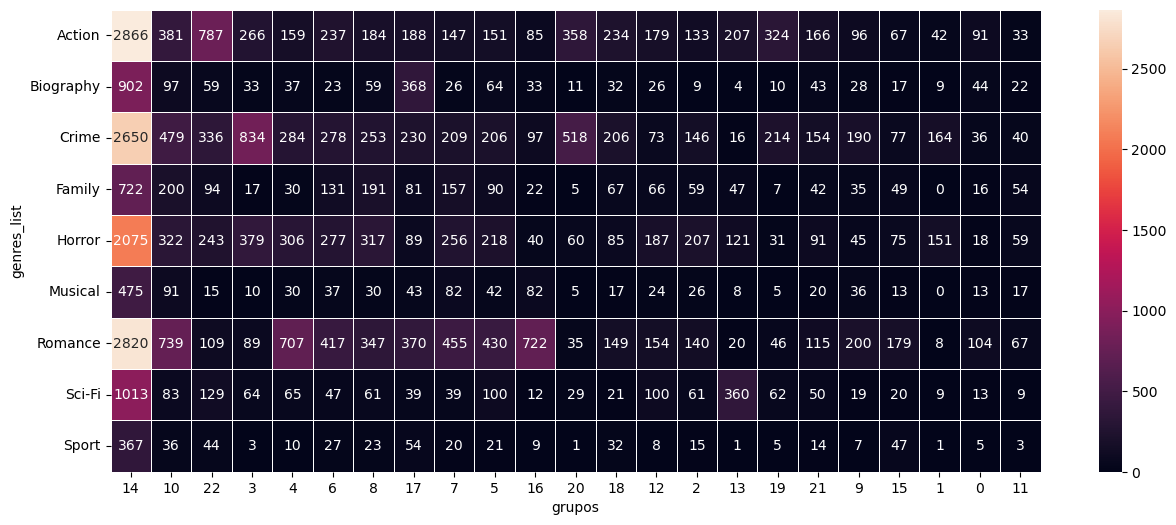

In [32]:
f, ax = plt.subplots(figsize=(15, 6))
sns.heatmap(generosXgrupos, annot=True, fmt="d", linewidths=0.5, ax=ax)

**Mapa de Calor Colunas Normalizadas - Figura 2**

In [33]:
# Normalizando os valores das colunas
generos_norm = generosXgrupos.apply(lambda x: (x - x.min()) / (x.max() - x.min()))
generos_norm

grupos,14,10,22,3,4,6,8,17,7,5,...,12,2,13,19,21,9,15,1,0,11
genres_list,,,,,,,,,,,,,,,,,,,,,
Action,1.000000,0.490754,1.000000,0.316486,0.213773,0.543147,0.496914,0.450151,0.291954,0.317848,...,0.955307,0.626263,0.573816,1.000000,1.000000,0.461140,0.325301,0.256098,0.868687,0.468750
Biography,0.214086,0.086771,0.056995,0.036101,0.038737,0.000000,0.111111,0.993958,0.013793,0.105134,...,0.100559,0.000000,0.008357,0.015674,0.190789,0.108808,0.024096,0.054878,0.393939,0.296875
Crime,0.913565,0.630156,0.415803,1.000000,0.393113,0.647208,0.709877,0.577039,0.434483,0.452323,...,0.363128,0.691919,0.041783,0.655172,0.921053,0.948187,0.385542,1.000000,0.313131,0.578125
Family,0.142057,0.233286,0.102332,0.016847,0.028694,0.274112,0.518519,0.126888,0.314943,0.168704,...,0.324022,0.252525,0.128134,0.006270,0.184211,0.145078,0.216867,0.000000,0.111111,0.796875
Horror,0.683473,0.406828,0.295337,0.452467,0.424677,0.644670,0.907407,0.151057,0.542529,0.481663,...,1.000000,1.000000,0.334262,0.081505,0.506579,0.196891,0.373494,0.920732,0.131313,0.875000
Musical,0.043217,0.078236,0.000000,0.008424,0.028694,0.035533,0.021605,0.012085,0.142529,0.051345,...,0.089385,0.085859,0.019499,0.000000,0.039474,0.150259,0.000000,0.000000,0.080808,0.218750
Romance,0.981593,1.000000,0.121762,0.103490,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.815642,0.661616,0.052925,0.128527,0.664474,1.000000,1.000000,0.048780,1.000000,1.000000
Sci-Fi,0.258503,0.066856,0.147668,0.073406,0.078910,0.060914,0.117284,0.000000,0.043678,0.193154,...,0.513966,0.262626,1.000000,0.178683,0.236842,0.062176,0.042169,0.054878,0.080808,0.093750
Sport,0.000000,0.000000,0.037565,0.000000,0.000000,0.010152,0.000000,0.045317,0.000000,0.000000,...,0.000000,0.030303,0.000000,0.000000,0.000000,0.000000,0.204819,0.006098,0.000000,0.000000


<Axes: xlabel='grupos', ylabel='genres_list'>

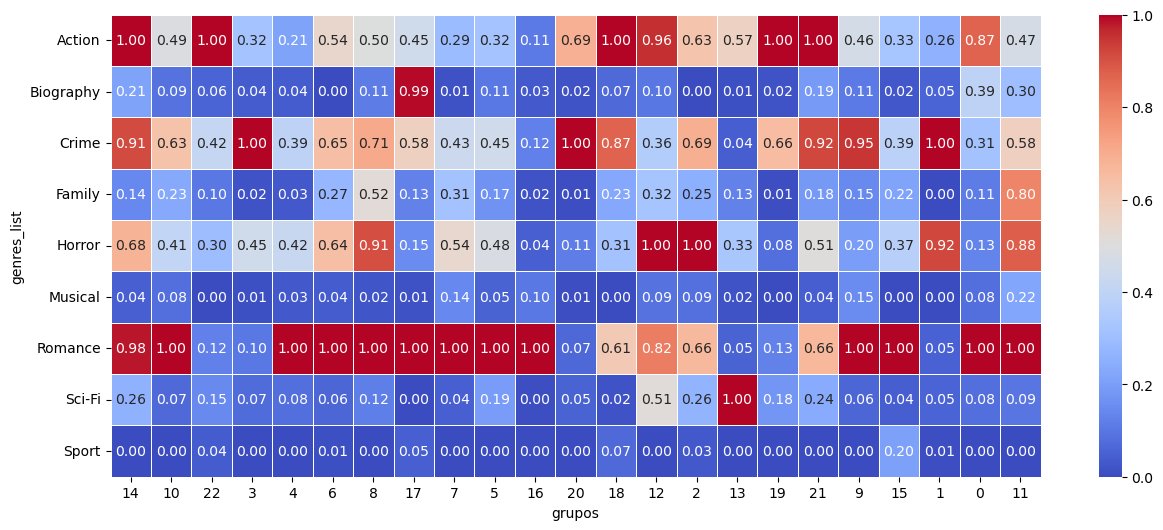

In [34]:
f, ax = plt.subplots(figsize=(15, 6))
sns.heatmap(generos_norm, cmap='coolwarm', annot=True, fmt='.2f', linewidths=0.5, ax=ax)

**Mapa de Calor Porcentagem de Generos nos Grupos - Figura 3**

In [35]:
generos_por = generosXgrupos.apply(lambda x: x / x.sum())
generos_por

grupos,14,10,22,3,4,6,8,17,7,5,...,12,2,13,19,21,9,15,1,0,11
genres_list,,,,,,,,,,,,,,,,,,,,,
Action,0.206335,0.156919,0.433370,0.156932,0.097666,0.160787,0.125597,0.128591,0.105679,0.114221,...,0.219094,0.167085,0.264031,0.460227,0.238849,0.146341,0.123162,0.109375,0.267647,0.108553
Biography,0.064939,0.039951,0.032489,0.019469,0.022727,0.015604,0.040273,0.251710,0.018692,0.048411,...,0.031824,0.011307,0.005102,0.014205,0.061871,0.042683,0.031250,0.023438,0.129412,0.072368
Crime,0.190785,0.197282,0.185022,0.492035,0.174447,0.188602,0.172696,0.157319,0.150252,0.155825,...,0.089351,0.183417,0.020408,0.303977,0.221583,0.289634,0.141544,0.427083,0.105882,0.131579
Family,0.051980,0.082372,0.051762,0.010029,0.018428,0.088874,0.130375,0.055404,0.112868,0.068079,...,0.080783,0.074121,0.059949,0.009943,0.060432,0.053354,0.090074,0.000000,0.047059,0.177632
Horror,0.149388,0.132619,0.133811,0.223599,0.187961,0.187924,0.216382,0.060876,0.184040,0.164902,...,0.228886,0.260050,0.154337,0.044034,0.130935,0.068598,0.137868,0.393229,0.052941,0.194079
Musical,0.034197,0.037479,0.008260,0.005900,0.018428,0.025102,0.020478,0.029412,0.058950,0.031770,...,0.029376,0.032663,0.010204,0.007102,0.028777,0.054878,0.023897,0.000000,0.038235,0.055921
Romance,0.203024,0.304366,0.060022,0.052507,0.434275,0.282904,0.236860,0.253078,0.327103,0.325265,...,0.188494,0.175879,0.025510,0.065341,0.165468,0.304878,0.329044,0.020833,0.305882,0.220395
Sci-Fi,0.072930,0.034185,0.071035,0.037758,0.039926,0.031886,0.041638,0.026676,0.028037,0.075643,...,0.122399,0.076633,0.459184,0.088068,0.071942,0.028963,0.036765,0.023438,0.038235,0.029605
Sport,0.026422,0.014827,0.024229,0.001770,0.006143,0.018318,0.015700,0.036936,0.014378,0.015885,...,0.009792,0.018844,0.001276,0.007102,0.020144,0.010671,0.086397,0.002604,0.014706,0.009868


<Axes: xlabel='grupos', ylabel='genres_list'>

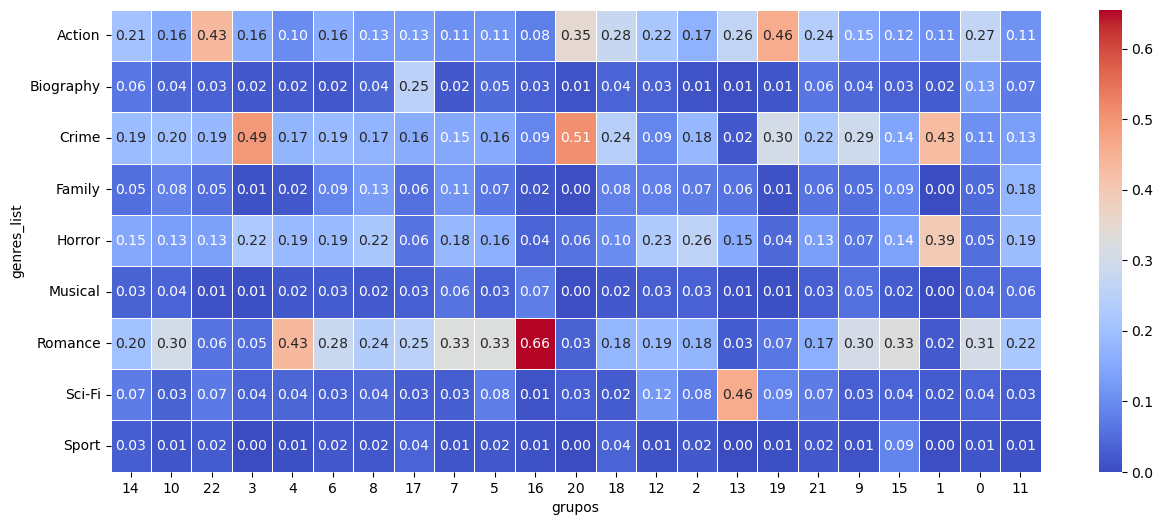

In [36]:
f, ax = plt.subplots(figsize=(15, 6))
sns.heatmap(generos_por, cmap='coolwarm', annot=True, fmt='.2f', linewidths=0.5, ax=ax)

## Agrupamento Espectral

### Configuração dos Dados

In [37]:
filmes_espec_df = filmes_df[['genres', 'sinopse']].copy()
filmes_espec_df['genres_list'] = filmes_espec_df['genres'].apply(lambda x: x.split(sep=','))
filmes_espec_df

,genres,sinopse,genres_list
0,Family,When two kids find and play a magical board ga...,[Family]
1,Romance,John and Max resolve to save their beloved bai...,[Romance]
2,Romance,"Based on Terry McMillan's novel, this film fol...",[Romance]
3,"Romance,Family",George Banks must deal not only with his daugh...,"[Romance, Family]"
4,"Crime,Action",A group of high-end professional thieves start...,"[Crime, Action]"
...,...,...,...
30353,Biography,"""I'll look at you, but not at the camera. It c...",[Biography]
30354,Biography,A musical biography of the great Russian class...,[Biography]
30355,"Crime,Horror",An evil genius uses poison gas to avenge himse...,"[Crime, Horror]"
30356,Romance,A young man narrates his past on how his fathe...,[Romance]


In [38]:
# Filmes com mais de um genero foram multiplicados para que existam apenas um genero por filme
filmes_espec_df = filmes_espec_df.explode('genres_list')
filmes_espec_df

,genres,sinopse,genres_list
0,Family,When two kids find and play a magical board ga...,Family
1,Romance,John and Max resolve to save their beloved bai...,Romance
2,Romance,"Based on Terry McMillan's novel, this film fol...",Romance
3,"Romance,Family",George Banks must deal not only with his daugh...,Romance
3,"Romance,Family",George Banks must deal not only with his daugh...,Family
...,...,...,...
30354,Biography,A musical biography of the great Russian class...,Biography
30355,"Crime,Horror",An evil genius uses poison gas to avenge himse...,Crime
30355,"Crime,Horror",An evil genius uses poison gas to avenge himse...,Horror
30356,Romance,A young man narrates his past on how his fathe...,Romance


**Amostra Aleatória - 20000**

In [39]:
# Amostra aleatória
filmes_espec_df = filmes_espec_df.sample(n=20000)
filmes_espec_df

,genres,sinopse,genres_list
7307,Biography,"In Biblical times, a girl disguises her Jewish...",Biography
13357,Horror,A journey that takes one man into the bowels o...,Horror
20042,Horror,An American nanny is shocked that her new Engl...,Horror
2935,Sport,Johnny's the top high-school football player a...,Sport
12270,"Crime,Action",A young boy is magically transported back in t...,Action
...,...,...,...
25314,Horror,After delivering an eviction notice to a myste...,Horror
23886,"Sci-Fi,Action","It is the last, great war. Out of the wreckage...",Sci-Fi
14625,"Sci-Fi,Action",A kickboxing champion is forced to fight cybor...,Sci-Fi
2197,Crime,"In post-war Austria, young, handsome country l...",Crime


### TF-IDF

In [40]:
X = vectorizer.fit_transform(filmes_espec_df['sinopse'])

c:\Users\alanz\anaconda3\Lib\site-packages\sklearn\feature_extraction\text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [41]:
matriz_tf_idf = pd.DataFrame(X.todense(), columns = vectorizer.get_feature_names_out())
matriz_tf_idf

,abandon,abduct,abil,abl,aboard,abroad,abus,academi,accept,access,...,young men,young peopl,young son,young woman,young women,younger,younger brother,youngster,youth,zombi
0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,0.0,0.230706,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.172427,0.0,0.0,0.0,0.0,0.0,0.0
19996,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
19997,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
19998,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0


### Dimensionalidade - SVD

In [42]:
svd = make_pipeline(TruncatedSVD(n_components=3000), Normalizer(copy=False))

In [43]:
svd.fit(X)

Pipeline(steps=[('truncatedsvd', TruncatedSVD(n_components=3000)),
                ('normalizer', Normalizer(copy=False))])

#### Curva - Fração Cumulativa da Variância Explicada

Text(0, 0.5, '$f(k)$ - Fração cumulativa da variância explicada')

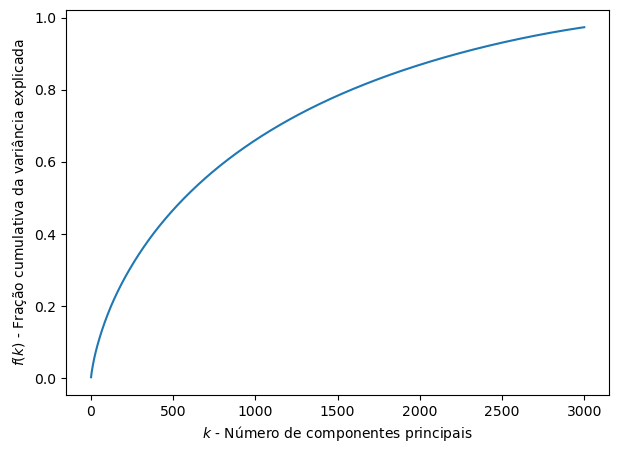

In [44]:
fig = plt.figure(figsize=(7, 5))
plt.plot([i for i in range(1, svd[0].n_components + 1)], np.cumsum(svd[0].explained_variance_ratio_))
plt.xlabel(r'$k$ - Número de componentes principais')
plt.ylabel(r'$f(k)$ - Fração cumulativa da variância explicada')

In [45]:
X_REDUCED = svd.transform(X)

### Verificando Algorimo Espectral - Escolha do K

Text(0, 0.5, 'Autovalor')

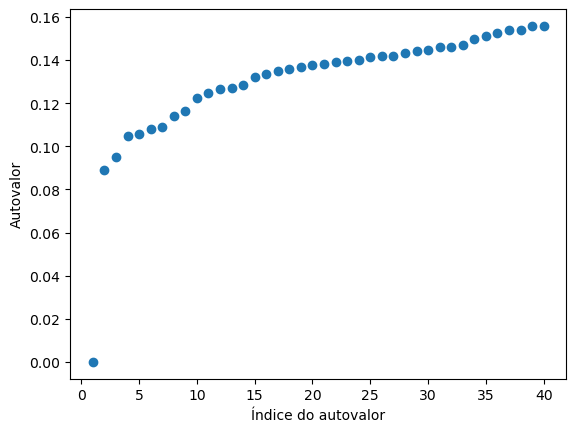

In [46]:
from sklearn.neighbors import kneighbors_graph
from scipy.sparse import csgraph
from numpy import linalg as LA

# 1 Construindo a matriz de adjacências do grafo de vizinhos mais próximos.
G = kneighbors_graph(X_REDUCED, n_neighbors = 10, include_self = True)
A = 0.5 * (G + G.T)

# 2 Construindo a Laplaciana Normalizada
L = csgraph.laplacian(A, normed = True).todense()

# 3 Obtendo os autovalores da Laplaciana Normalizada
# Valores já estão ordenados em ordem crescente.
values, _ = LA.eigh(L)

# 4 Plotando os valores dos 'gaps' e escolhendo um k adequado.
plt.scatter([i for i in range(1, 41)], values[:40])
plt.xlabel('Índice do autovalor')
plt.ylabel('Autovalor')

### Agrupando

In [47]:
k_group = 6
m = SpectralClustering(n_clusters = k_group, affinity = 'nearest_neighbors', n_neighbors = 10)
m.fit(X_REDUCED)

SpectralClustering(affinity='nearest_neighbors', n_clusters=6)

### Análise dos Grupos

#### Atribuindo os Grupos

In [48]:
filmes_espec_df['grupos'] = m.labels_

#### Matriz Generos X Grupos

In [49]:
generosXgrupos = filmes_espec_df.groupby(['genres_list', 'grupos']).size().unstack(fill_value=0)
generosXgrupos

grupos,0,1,2,3,4,5
genres_list,,,,,,
Action,3842,1,7,1,6,31
Biography,1057,1,1,0,0,19
Crime,4101,9,23,3,4,20
Family,1176,1,1,0,5,4
Horror,2934,0,3,1,3,6
Musical,612,0,2,0,2,4
Romance,4344,3,12,14,14,37
Sci-Fi,1292,0,2,1,3,1
Sport,396,0,0,0,0,1


**Grupos ordenados em ordem decrescente em relação à quantidade de filmes no grupos**

In [50]:
generosXgrupos = generosXgrupos[generosXgrupos.sum().sort_values(ascending=False).index]
generosXgrupos

grupos,0,5,2,4,3,1
genres_list,,,,,,
Action,3842,31,7,6,1,1
Biography,1057,19,1,0,0,1
Crime,4101,20,23,4,3,9
Family,1176,4,1,5,0,1
Horror,2934,6,3,3,1,0
Musical,612,4,2,2,0,0
Romance,4344,37,12,14,14,3
Sci-Fi,1292,1,2,3,1,0
Sport,396,1,0,0,0,0


**Mapa de Calor Geral - Figura 1**

<Axes: xlabel='grupos', ylabel='genres_list'>

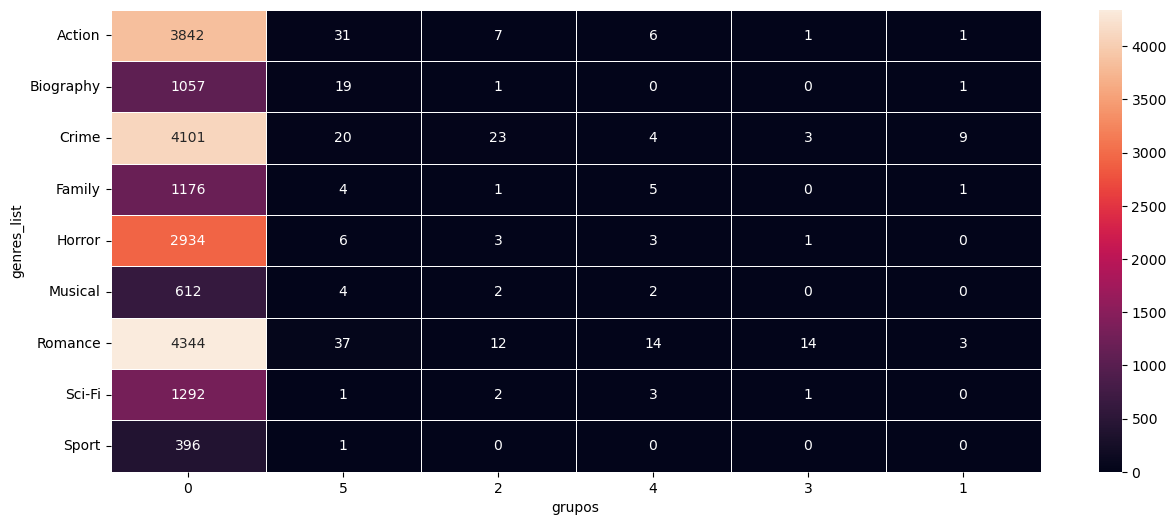

In [51]:
f, ax = plt.subplots(figsize=(15, 6))
sns.heatmap(generosXgrupos, annot=True, fmt="d", linewidths=0.5, ax=ax)

**Mapa de Calor Colunas Normalizadas - Figura 2**

In [52]:
# Normalizando os valores das colunas
generos_norm = generosXgrupos.apply(lambda x: (x - x.min()) / (x.max() - x.min()))
generos_norm

grupos,0,5,2,4,3,1
genres_list,,,,,,
Action,0.872847,0.833333,0.304348,0.428571,0.071429,0.111111
Biography,0.167427,0.500000,0.043478,0.000000,0.000000,0.111111
Crime,0.938450,0.527778,1.000000,0.285714,0.214286,1.000000
Family,0.197568,0.083333,0.043478,0.357143,0.000000,0.111111
Horror,0.642857,0.138889,0.130435,0.214286,0.071429,0.000000
Musical,0.054711,0.083333,0.086957,0.142857,0.000000,0.000000
Romance,1.000000,1.000000,0.521739,1.000000,1.000000,0.333333
Sci-Fi,0.226950,0.000000,0.086957,0.214286,0.071429,0.000000
Sport,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


<Axes: xlabel='grupos', ylabel='genres_list'>

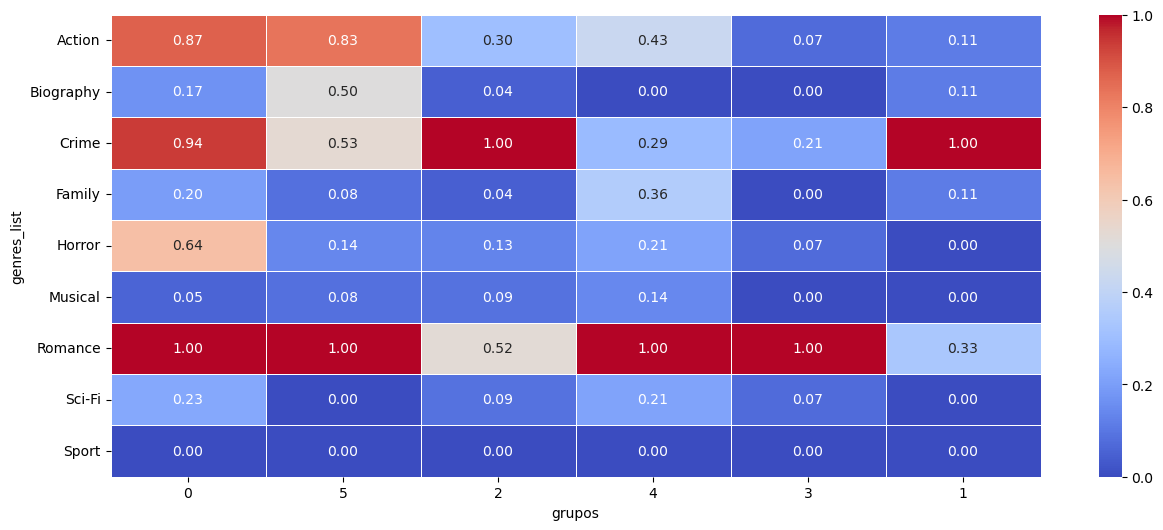

In [53]:
f, ax = plt.subplots(figsize=(15, 6))
sns.heatmap(generos_norm, cmap='coolwarm', annot=True, fmt='.2f', linewidths=0.5, ax=ax)

**Mapa de Calor Porcentagem de Generos nos Grupos - Figura 3**

In [54]:
generos_por = generosXgrupos.apply(lambda x: x / x.sum())
generos_por

grupos,0,5,2,4,3,1
genres_list,,,,,,
Action,0.194492,0.252033,0.137255,0.162162,0.05,0.066667
Biography,0.053508,0.154472,0.019608,0.000000,0.00,0.066667
Crime,0.207604,0.162602,0.450980,0.108108,0.15,0.600000
Family,0.059532,0.032520,0.019608,0.135135,0.00,0.066667
Horror,0.148527,0.048780,0.058824,0.081081,0.05,0.000000
Musical,0.030981,0.032520,0.039216,0.054054,0.00,0.000000
Romance,0.219905,0.300813,0.235294,0.378378,0.70,0.200000
Sci-Fi,0.065404,0.008130,0.039216,0.081081,0.05,0.000000
Sport,0.020047,0.008130,0.000000,0.000000,0.00,0.000000


<Axes: xlabel='grupos', ylabel='genres_list'>

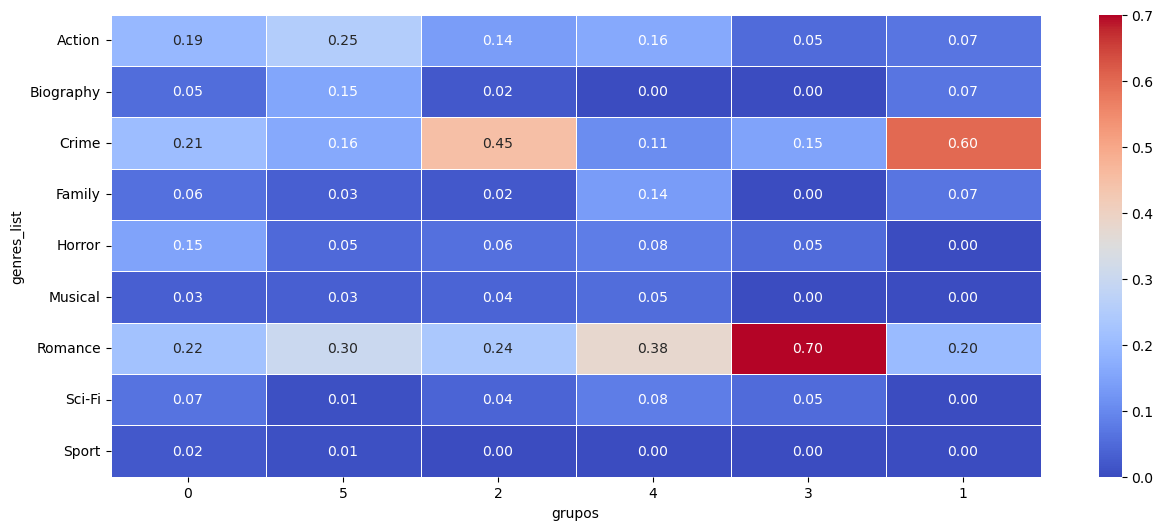

In [55]:
f, ax = plt.subplots(figsize=(15, 6))
sns.heatmap(generos_por, cmap='coolwarm', annot=True, fmt='.2f', linewidths=0.5, ax=ax)